###Latent Semantic Indexing of Yoga Reviews

Here we apply the following procedure:
 1. Concatenate the reviews by yoga business, making sure there are no duplicate reviews 
    for a given business.
 2. Convert to lower case, remove accents, tokenize, and retain only tokens with alphabetical characters.
 3. Remove stop words.
 4. Stem.
 5. Create a corpus dictionary: (integer word ID, word, word frequency in corpus).
 6. Remove tokens that appear too often or not often enough.
 7. Convert each concatenated studio review into bag-of-words format: 
    a list of (token ID, token count) 2-tuples.
 8. Apply tf-idf transformation to corpus.
 9. Apply Latent Semantic Indexing to corpus, with number of topics set to 10, 20...
 10. Check singular value calculation, look at the resulting topics.

In [2]:
'''
First get the packages we'll need.
'''
from   pymongo import MongoClient
import logging
import nltk
from   gensim import corpora, models, similarities, matutils, utils
from   collections import defaultdict
from   pprint import pprint
import re
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [37]:
'''
Set region: NYC or LA.
Make a list of the reviews we'll be analyzing, concatenating by business.
'''
region = "LA"

client = MongoClient()
if region == "NYC":
    yoga = client.dsbc.yyrnyc
    print('Opening NYC database...')
else:
    yoga = client.dsbc.yyrla
    print('Opening LA database...')
    
print('Total number of Yoga businesses = %i' %yoga.count())

cursor          = yoga.find()
studio_names    = []
studio_reviews  = []
studio_ratings  = []
for record in cursor:
    reviews = []
    for review in record["usr_text"]:
        if review:
            # Save review:
            reviews.append(review)

    # Eliminate duplicate reviews for a given studio
    # (different studios may still "share" a review):
    n_reviews = len(reviews)
    ureviews  = []
    for review in set(reviews):
        ureviews.append(review)
    n_ureviews = len(ureviews)
    
    # Concatenate the unique reviews by business.
    con_review = ""
    for review in ureviews:
        con_review += " " + review

    if con_review:
        studio = record["biz_name"]+" [at] "+record["biz_address"]
        studio_names.append(studio)
        studio_reviews.append(con_review)
        studio_ratings.append(record["biz_rating"])
        
print('Number of reviewed Yoga businesses = %i' %len(studio_reviews))

Opening LA database...
Total number of Yoga businesses = 749
Number of reviewed Yoga businesses = 749


In [46]:
'''
Remove stop words, tokenize and stem.
'''

# Get list of stopwords.
stoplist = nltk.corpus.stopwords.words('english')
stoplist.append(u'\u0027s')   # "'s" as in "he's"
stoplist.append(u'n\u0027t')  # "n't" as in "he hasn't"
stoplist.append(u'\u0027m')   # "'m" as in "I'm"

# Convert to lower case, remove accents, and tokenize (removing punctuation and numbers).
studio_reviews_1 = [list(utils.tokenize(studio_review,lowercase=True,deacc=True)) for studio_review in studio_reviews]

# Remove stop words.
studio_reviews_2 = [[word for word in studio_review if word not in stoplist] for studio_review in studio_reviews_1]

# Stem.
stemmer          = nltk.stem.porter.PorterStemmer()
studio_reviews_3 = [[stemmer.stem(word) for word in studio_review] for studio_review in studio_reviews_2]

# Create a dictionary to map stems to words (this is a one-to-many map, but this shouldn't matter much).
stem_to_word = defaultdict(str)
for studio_review in studio_reviews_2:
    for word in studio_review:
        word_stem = stemmer.stem(word)
        stem_to_word[word_stem] = word

#pprint(studio_reviews_3[0])

In [91]:
'''
Create a corpus dictionary: (integer word ID, word, word frequency in corpus).
Remove words that appear too infrequently or too frequently.

Load dictionary if it already exists on disk.
'''

make_dict = True

if region == "NYC":
    fname1 = "yoga_studios_nyc.dict"
    fname2 = "yoga_studios_nyc_txt.dict"
else:
    fname1 = "yoga_studios_la.dict"
    fname2 = "yoga_studios_la_txt.dict"
    
if make_dict:
    dictionary = corpora.Dictionary( studio_reviews_3 )
    dictionary.filter_extremes( no_below=0, no_above=0.7, keep_n=None )
    dictionary.save( fname1 )
    dictionary.save_as_text( fname2, sort_by_word=False )
else:
    dictionary = corpora.Dictionary.load( fname1 )
    
print(dictionary)
print(stem_to_word[dictionary[1]])
print(stem_to_word[dictionary[2]])
print(stem_to_word[dictionary[3]])
print(len(dictionary))

Dictionary(26644 unique tokens: [u'fawn', u'fawk', u'yogibarr', u'woodi', u'alsdfoidfjdjkalalw']...)
fawk
yogibarre
woody
26644


In [92]:
'''
Convert the tokenized reviews of the corpus to bags of words,
or load the corpus from disk if it already exists.
'''

if region == "NYC":
    fname3 = "yoga_studios_nyc.mm"
else:
    fname3 = "yoga_studios_la.mm"
    
# Convert each concatenated studio review into bag-of-words format: a list of (token ID, token count) 2-tuples.
corpus_bow = [dictionary.doc2bow(studio_review) for studio_review in studio_reviews_3]

# Store to disk in Matrix Market format.
corpora.MmCorpus.serialize( fname3, corpus_bow )

# Make a random access stream.
ys_mm = corpora.MmCorpus( fname3 )
    
print(ys_mm)
#print(ys_mm[1]) # retrieving document No. 1 (for example)

MmCorpus(749 documents, 26644 features, 469320 non-zero entries)


In [93]:
'''
Apply tf-idf transformation to corpus: Compute document frequencies of all the features.
'''
tfidf = models.TfidfModel(corpus_bow)
corpus_tfidf = tfidf[corpus_bow]

In [96]:
'''
Apply Latent Semantic Indexing to the corpus.
'''
ntops    = 1000
if region == "NYC":
    lsi_file = 'yoga_studios_nyc_'+str(ntops)
else:
    lsi_file = 'yoga_studios_la_'+str(ntops)
    
make_lsi = True
if make_lsi:
    lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=ntops, onepass=True, power_iters=2)
    lsi.save(lsi_file)
else:
    lsi = models.LsiModel.load(lsi_file)
    
corpus_lsi = lsi[corpus_tfidf]

Quadrature difference between singular value calculations = 0.000001


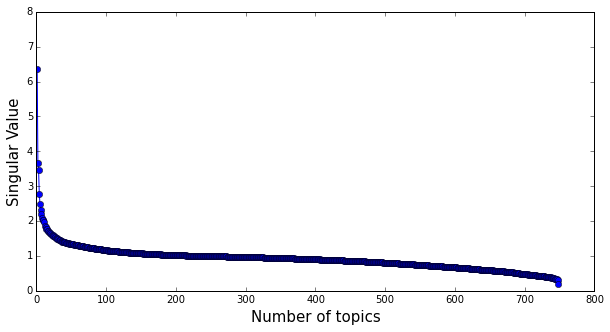

SV=6.359:  0.213*studio + 0.213*gym + 0.140*pilates + 0.129*instructors + 0.129*massage + 0.112*workout
SV=3.662: -0.793*massage - 0.326*thai - 0.146*masseuse + 0.138*gym - 0.116*spa - 0.105*knots
SV=3.466: -0.484*gym + 0.270*studio - 0.220*machines - 0.179*locker - 0.171*pools + 0.168*pilates
SV=2.770:  0.504*pilates - 0.277*bikram + 0.267*barre + 0.182*reformer - 0.179*hot + 0.160*physique
SV=2.500:  0.449*pilates - 0.438*barre - 0.285*physique - 0.281*popped - 0.244*bar - 0.185*method
SV=2.325:  0.375*pilates + 0.349*bikram - 0.244*pole + 0.219*hot - 0.191*dancing + 0.147*reformer
SV=2.189: -0.527*pole - 0.318*dancing + 0.274*dr - 0.206*aerial + 0.158*acupuncture - 0.153*spin
SV=2.090:  0.590*spin - 0.288*pole + 0.252*ya + 0.247*bike - 0.180*bikram + 0.171*cycling
SV=2.033:  0.397*dr + 0.316*bikram + 0.303*spin - 0.197*store + 0.184*acupuncture - 0.172*lululemon
SV=2.021: -0.398*store - 0.371*lululemon - 0.281*dr - 0.224*lulu + 0.223*crossfit - 0.222*pants
SV=1.980:  0.482*crossfit 

In [97]:
'''
Check singular value calculation and plot singular values versus number of topics.
'''
sv    = lsi.projection.s
np_sv = np.linalg.svd(matutils.corpus2dense(corpus_lsi,ntops))
test  = np.sqrt(sum([(np_sv[1][i]-sv[i])**2 for i in range(len(sv))]))
print('Quadrature difference between singular value calculations = %f' % test)
    
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(10,5) )
ax.plot( range(1,len(sv)+1), sv, '-o' )
ax.set_xlabel( 'Number of topics', fontsize=15)
ax.set_ylim(0.0,8.0)
ax.set_ylabel( 'Singular Value', fontsize=15 )
plt.show()
# fig.savefig("nyc_singular_values.pdf")

nwords  = 6
ntopics = min(ntops,20)
uv = lsi.projection.u
term_list = [i for i in range(len(dictionary))]
for jnd,vector in enumerate(zip(*uv)):
    out_string = "SV="+"{:.3f}".format(sv[jnd])+": "
    for ind,x in enumerate(sorted(zip(vector,term_list),key=lambda x: -abs(x[0]))[:nwords]):
        if x[0]>0.0:
            if ind>0:
                out_string += " + "+"{:.3f}".format(x[0])+"*"+stem_to_word[dictionary[x[1]]]
            else:
                out_string += " "+"{:.3f}".format(x[0])+"*"+stem_to_word[dictionary[x[1]]]
        else:
            if ind>0:
                out_string += " - "+"{:.3f}".format(abs(x[0]))+"*"+stem_to_word[dictionary[x[1]]]
            else:
                out_string += "-"+"{:.3f}".format(abs(x[0]))+"*"+stem_to_word[dictionary[x[1]]]
    print(out_string)
    if jnd == ntopics-1:
        break
    
#lsi.show_topics( num_topics=ntopics, num_words=nwords, log=False, formatted=True )

In [101]:
total_variance = sum([sv[i]**2 for i in range(len(sv))])
print("Total Variance = %f" %total_variance)

partial_variance = 0
old_explained_variance = 0
for ind,value in enumerate(sv):
    partial_variance += value**2
    explained_variance = partial_variance/total_variance
    if old_explained_variance<0.70 and explained_variance >=0.70:
        print('Explained Variance = 0.70 at ind = %i, SV = %f' %(ind,value))
    old_explained_variance = explained_variance

Total Variance = 749.000000
Explained Variance = 0.70 at ind = 337, SV = 0.946582
